# Get Buildings and Streets and run Morphometrics

Gets buildings and streets layer and create morphometrics statistics.

# Import modules

In [1]:
import numpy as np
import pandas as pd
import osmnx as ox
import networkx as nx
import geopandas as gpd
import imageio
import momepy
import math

import time

from pathlib import Path

import warnings
warnings.filterwarnings("ignore")

# Choose City

In [2]:
city_list = [
    'Melbourne',
    'Jerusalem',
    'Buenos Aires',
    'Paris',
    'Rotterdam',
    'Nashville',
    'Singapore',
    'Cape Town',
    'New York',
    'Los Angeles',
    'Chicago',
    'Boston',
    'Austin',
    'Seattle',
    'Philadelphia',
    'Pittsburgh',
    'Washington DC',
    'San Francisco',
    'SF Bay Area ',
    'Raleigh',
    'Milwaukee',
    'Portland',
    'San Diego',
    'Denver',
    'Miami',
    'Saint Louis',
    'Houston',
    'Atlanta',
    'Phoenix',
    'Detroit',
    'Minneapolis',
    'Savannah',
    'Charlotte',
    'Las Vegas',
    'Cincinnati',
    'Kansas City',
    'Nashville']

In [3]:
city = city_list[8]
print("City:", city)

City: New York


# Buildings and Streets

## Read Geopackage

In [4]:
data_folder = Path("../data/")
input_file = data_folder / "0_boundaries" / (city + ".gpkg")

gdf = gpd.read_file(input_file, driver='GPKG')
# Force gdf projection
print("Reading:", input_file)
gdf = ox.project_gdf(gdf,to_crs='epsg:4326',to_latlong=False) 

Reading: ../data/0_boundaries/New York.gpkg


<Axes: >

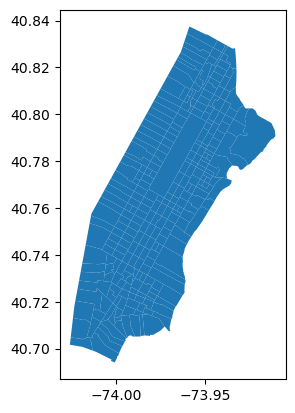

In [5]:
gdf.plot()

## Get Master polygon

In [6]:
# Create unique ID
gdf = gdf.reset_index(drop=True)
gdf['UID'] = gdf.index

# Establish bounds DataFrame (everything so we can do one query)
gdf['collapse'] = 0
gdf_collapsed = gdf.dissolve(by='collapse')

## Get Streets

In [7]:
# G = ox.graph_from_polygon(gdf_collapsed['geometry'][0], network_type='drive', retain_all=True) 
# out_file = data_folder / "1_buildings_streets" / (city + " - streets.gpkg")
# ox.save_graph_geopackage(G, filepath=out_file)
# print("Saved:", out_file)

## Get Buildings

In [8]:
# tags = {"building": True}
# buildings = ox.geometries_from_polygon(gdf_collapsed['geometry'][0], tags)
# buildings = buildings[['geometry','name']]
# buildings_save = buildings.drop(labels="node", axis=0)

# # Save
# out_file = data_folder / "1_buildings_streets" / (city + " - buildings.gpkg")
# buildings_save.to_file(out_file, driver='GPKG')
# print("Saved:", out_file)

# Morphometrics

## Helper functions

In [9]:
def reverse_bearing(x):
    return x + 180 if x < 180 else x - 180

def get_bearings(G, ID):
    # calculate the edge bearings
    Gu = ox.add_edge_bearings(ox.get_undirected(G))
    
    weight_by_length = False

    bearings = {}
    if weight_by_length:
        # weight bearings by length (meters)
        city_bearings = []
        for u, v, k, d in Gu.edges(keys=True, data=True):
            city_bearings.extend([d['bearing']] * int(d['length']))
        b = pd.Series(city_bearings)
        bearings[ID] = pd.concat([b, b.map(reverse_bearing)]).reset_index(drop='True')
    else:
        # don't weight bearings, just take one value per street segment
        b = pd.Series([d['bearing'] for u, v, k, d in Gu.edges(keys=True, data=True)])
        bearings[ID] = pd.concat([b, b.map(reverse_bearing)]).reset_index(drop='True')
    return bearings[ID]

def count_and_merge(n, bearings):
    # make twice as many bins as desired, then merge them in pairs
    # prevents bin-edge effects around common values like 0° and 90°
    n = n * 2
    bins = np.arange(n + 1) * 360 / n
    count, _ = np.histogram(bearings, bins=bins)
    
    # move the last bin to the front, so eg 0.01° and 359.99° will be binned together
    count = np.roll(count, 1)
    return count[::2] + count[1::2]

def get_orientation_order(count):  
    try:
        H0 = 0
        for i in range(len(count)):
            Pi = (count[i]/sum(count))
            if Pi != 0:
                H0 += Pi*np.log(Pi)

        H0 = -1*H0
        Hmax = np.log(len(count))
        Hg = np.log(2)

        orientation_order = (1 - (((H0-Hg)/(Hmax-Hg))**2))
   
    except Exception as e:
        print(f'Error in orientation order {e}')

    return orientation_order

##### Functions to calculate compactness


def pp_compactness(geom): # Polsby-Popper
    p = geom.length
    a = geom.area    
    return (4*math.pi*a)/(p*p)

##### Functions to calculate fractal dimension

def fractal_dimension(Z, threshold=0.8):
    """Returns box-counting dimension of a 2D array.
    Args:
        Z: 2D array to be analysed.
        threshold: Cutoff for converting values in Z to 1 and 0.
    Returns:
        The estimated box counting dimension.
    """
    # Only for 2d image
    assert(len(Z.shape) == 2)
    def boxcount(Z, k):
        S = np.add.reduceat(np.add.reduceat(Z, np.arange(0, Z.shape[0], k), axis=0), np.arange(0, Z.shape[1], k), axis=1)
        # We count non-empty (0) and non-full boxes (k*k)
        return len(np.where((S > 0) & (S < k*k))[0])
    # Transform Z into a binary array
    Z = (Z < threshold)
    # Minimal dimension of image
    p = min(Z.shape)
    # Greatest power of 2 less than or equal to p
    n = 2**np.floor(np.log(p)/np.log(2))
    # Extract the exponent
    n = int(np.log(n)/np.log(2))
    # Build successive box sizes (from 2**n down to 2**1)
    sizes = 2**np.arange(n, 1, -1)
    # Actual box counting with decreasing size
    counts = []
    for size in sizes:
        counts.append(boxcount(Z, size))
    # Fit the successive log(sizes) with log (counts)
    coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
    return -coeffs[0]

##### Function to clean building heights

def clean_heights(x):
    try:
        return float(x)
    except ValueError:
        return 0

## Choose city

In [10]:
# city = city_list[9]
print("City:", city)

data_folder = Path("../data")
input_file = data_folder / "0_boundaries" / (city + ".gpkg")
print("Reading:", input_file)
gdf = gpd.read_file(input_file, driver='GPKG')

City: New York
Reading: ../data/0_boundaries/New York.gpkg


## Clean data

In [11]:
gdf['Center_point'] = gdf['geometry'].centroid
#Extract lat and lon from the centerpoint

gdf['lon'] = gdf.Center_point.map(lambda p: p.x)
gdf['lat'] = gdf.Center_point.map(lambda p: p.y)

gdf = gdf.drop(['Center_point'], axis = 1)

# Ensure crs is correct
gdf = ox.project_gdf(gdf,to_crs='epsg:4326',to_latlong=False) 

# Calculate area of every shape
temp = gdf.copy()
temp = temp.to_crs({'init': 'epsg:32630'})
temp["area_m^2"] = temp['geometry'].area
gdf["area_m^2"] = temp["area_m^2"]

## Define variables

In [12]:
# Scale Complexity
gdf['fractal-dimension'] = np.nan

# Spatial Complexity and Connectivity
gdf['shannon_entropy-street_orientation_order'] = np.nan
gdf['avg_street_length'] = np.nan
gdf['avg_betweenness_centrality'] = np.nan

# Built Complexity/Morphology
gdf['avg_building_area'] = np.nan
gdf['avg_building_compactness'] = np.nan

## Main loop

In [13]:
last_ID = 0
bookmark = True

t0 = time.perf_counter()
# iterate through boundaries    
for ID in gdf.index: 
    
    if ID > 5:
        break
    
    # Pick up where we left off or the loop broke
    if (ID != last_ID) and (bookmark == True):
        continue
    else:
        bookmark = False
    
    print(f"Run {ID+1} out of {len(gdf)}: ID = {ID}")
    
    try:
        # get primary geometry and load network
        polygon = gdf.loc[ID,'geometry']
        G = ox.graph_from_polygon(polygon, network_type='drive', simplify=True, retain_all=False, truncate_by_edge=True, clean_periphery=True, custom_filter=None)
        
    except:
        pass
    
    ####################
    # Scale Complexity #
    ####################
    
    try:
        fp = f'./street-network-{ID}.png'
        ox.plot_graph(G,bgcolor='white',node_color='black',edge_color='black',show=False,close=True,dpi=150,save=True,filepath=fp)
        # I = imageio.imread(fp, as_gray="True")/255.0
        I = imageio.imread(fp, mode="L")/255.0
        ! rm $fp # comment if you want to save the plot
        print("Deleted:", fp)
        gdf.loc[ID,'fractal-dimension'] = fractal_dimension(I)
    except:
        raise
        pass
    
    #######################################
    # Spatial Complexity and Connectivity #
    #######################################
    
    try:
        # get 'shannon_entropy-street_orientation_order'
        bearings = get_bearings(G, ID)
        count = count_and_merge(36, bearings)
        street_orientation_order = get_orientation_order(count)
        gdf.loc[ID,'shannon_entropy-street_orientation_order'] = street_orientation_order
        #print(street_orientation_order)
    except:
        pass
    
    try:
        # get basic stats from network
        basic = ox.stats.basic_stats(G, area=gdf.loc[ID,"area_m^2"]) # basic stats
    
        # allocate stats
        gdf.loc[ID,'avg_street_length'] = basic['street_length_avg']
    except:
        pass
    
    try:
        # multiple centrality assessment
        streets_graph = ox.projection.project_graph(G)
        edges = ox.graph_to_gdfs(ox.get_undirected(streets_graph), nodes=False, edges=True,node_geometry=False, fill_edge_geometry=True)
        primal = momepy.gdf_to_nx(edges, approach='primal')
        primal = momepy.betweenness_centrality(primal, name='betweenness_metric_n', mode='nodes', weight='mm_len')
        nodes = momepy.nx_to_gdf(primal, lines=False)

        gdf.loc[ID,'avg_betweenness_centrality'] = np.mean(nodes['betweenness_metric_n'])
    except:
        pass
    
    ###############################
    # Built Complexity/Morphology #
    ###############################
    
    try:
        buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})
        buildings_gdf_projected = ox.project_gdf(buildings_gdf)
        buildings_gdf_projected = buildings_gdf_projected.reset_index()
        buildings_gdf_projected = buildings_gdf_projected[buildings_gdf_projected.geom_type.isin(['Polygon', 'MultiPolygon'])]

        buildings = momepy.preprocess(buildings_gdf_projected, size=30, compactness=True, islands=True)
        buildings['uID'] = momepy.unique_id(buildings)

    except:
        pass
    
    try:
        blg_area = momepy.Area(buildings)
        buildings['area'] = blg_area.series
        gdf.loc[ID,'avg_building_area'] = buildings['area'].mean()

    except:
        pass
    
    try:
        buildings['compactness'] = buildings['geometry'].apply(lambda x: pp_compactness(x))
        gdf.loc[ID,'avg_building_compactness'] = buildings['compactness'].mean()
    except:
        pass
    
    
gdf['UID'] = gdf.index 

t1 = time.perf_counter()
print(f"Time elapsed: {t1-t0:.0f} seconds.")

Run 1 out of 275: ID = 0
Deleted: ./street-network-0.png
Loop 1 out of 2.


Identifying changes:   0%|          | 0/180 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/115 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/83 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/46 [00:00<?, ?it/s]

Run 2 out of 275: ID = 1


/tmp/ipykernel_98726/3816898763.py:35: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-1.png
Loop 1 out of 2.


/tmp/ipykernel_98726/3816898763.py:83: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Identifying changes:   0%|          | 0/341 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/234 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/159 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/110 [00:00<?, ?it/s]

Run 3 out of 275: ID = 2


/tmp/ipykernel_98726/3816898763.py:35: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-2.png


/tmp/ipykernel_98726/3816898763.py:83: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/342 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/248 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/158 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/101 [00:00<?, ?it/s]

Run 4 out of 275: ID = 3


/tmp/ipykernel_98726/3816898763.py:35: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-3.png
Loop 1 out of 2.


/tmp/ipykernel_98726/3816898763.py:83: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Identifying changes:   0%|          | 0/19 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/4 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/16 [00:00<?, ?it/s]

Changing geometry: 0it [00:00, ?it/s]

Run 5 out of 275: ID = 4


/tmp/ipykernel_98726/3816898763.py:35: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-4.png
Loop 1 out of 2.


/tmp/ipykernel_98726/3816898763.py:83: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Identifying changes:   0%|          | 0/116 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/67 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/65 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/33 [00:00<?, ?it/s]

Run 6 out of 275: ID = 5


/tmp/ipykernel_98726/3816898763.py:35: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-5.png
Loop 1 out of 2.


/tmp/ipykernel_98726/3816898763.py:83: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Identifying changes:   0%|          | 0/94 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/66 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/39 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/26 [00:00<?, ?it/s]

Time elapsed: 24 seconds.


## Report data availability

In [14]:
vars_of_interest = [
    'avg_betweenness_centrality',
    'fractal-dimension',
    'shannon_entropy-street_orientation_order',
    'avg_street_length',
    'avg_building_area',
    'avg_building_compactness']

for variable in vars_of_interest:
    if gdf[variable].isna().all():
        print(f"{variable:<40} -> missing")
    else:
        print(f"{variable:<40} -> available")

avg_betweenness_centrality               -> available
fractal-dimension                        -> available
shannon_entropy-street_orientation_order -> available
avg_street_length                        -> available
avg_building_area                        -> available
avg_building_compactness                 -> available


## Save file

In [15]:
out_file = data_folder / "2_morphometrics" / (city + " - morpho.gpkg")
print("Saving:", out_file)
gdf.to_file(out_file, driver='GPKG')

Saving: ../data/2_morphometrics/New York - morpho.gpkg
